# Initial EDA and Modelling for Scania Truck Data Classification Problem
Scania is looking to determine during a checkup whether the Air Pressure System (APS), the system that controls the trucks' ability to brake (among other things), is in need of replacement. They have provided a training set of 60,000 examples with over 170 features. Models are scored using a custom cost function that heavily penalizes Type II classification errors (false negatives) on a test set of 16,000 examples.

I only had the training set from the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks) available for most of the project, so all references in this notebook to the *test set* refer to a *holdout set from the training data*. I later found the [full dataset hosted on Kaggle](https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set). It includes the original data, which I use below, as well as the test set used in later notebooks and a processed training and test sets that have been standardized, scrubbed, and re-formatted by Kaggle user [ahk3](https://www.kaggle.com/ahkahk). I will be taking a look at other users' strategies after I've gotten my own implementation and score finished.

There are no label errors in the test and training sets. However, nearly every row is missing some kind of measurement. It will be necessary to impute the data, find a smart way of dropping NaN's, and learn from trends in the data.

In [1]:
# Custom Modules
import data_cleaning as dc
from custom_metrics import scania_score
from model_testing import cross_val_models

# Data Containers
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing: standardizing, undersampling, and oversampling, gridsearch
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import GridSearchCV, train_test_split,\
cross_val_score, StratifiedKFold, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
import imblearn

#Pipeline Experimentation
from sklearn.pipeline import make_pipeline

# Models: dummy, kNN, logistic regression, Naive Bayes, SVM
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model evaluation metrics
# ROC curve
# Proprietary cost function
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
auc, log_loss, confusion_matrix, f1_score, make_scorer, roc_auc_score, roc_curve

Using TensorFlow backend.


## EDA
The following blocks read in the data and do exploratory work on the data. The results from this have been condensed in the `ready_aps_data()` function within `data_cleaning.py`, but I've left the blocks here intact for illustrative purposes.


In [2]:
folder = 'aps-failure-at-scania-trucks-data-set/'
file = 'aps_failure_training_set.csv'
aps = pd.read_csv(folder+file)

In [3]:
# Nearly all data enters the dataframe as a string object.
aps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [4]:
# Checking for weird labels
print('Label values:', aps['class'].unique())
mask = aps['class']=='neg'
print('Negative class observations:',aps[mask]['class'].shape[0] )
print('Positive class observations:', aps[~mask]['class'].shape[0])

Label values: ['neg' 'pos']
Negative class observations: 59000
Positive class observations: 1000


In [5]:
# Create new dataframe for EDA
# For each column in dataframe, make that column numeric

X = aps.iloc[:,1:].copy(deep=True)
y = aps['class']

Some columns are majority `NaN` values, to the extent that I don't think I'll gain any information from using them.

In [8]:
# Sample of missing values, looking at the positive class only
X[~mask]['ab_000'].value_counts(dropna=False)

na    771
0     155
2      38
4      17
6       9
8       5
48      1
10      1
14      1
36      1
12      1
Name: ab_000, dtype: int64

In [9]:
# Convert target variable to numeric

print('Pre-conversion y', y.dtype, y.value_counts(), sep = '\n')
y = pd.Series([0 if lbl == 'neg' else 1 for lbl in y], name = 'class')
print('Post-conversion y', y.dtype, y.value_counts(), sep = '\n')

Pre-conversion y
object
neg    59000
pos     1000
Name: class, dtype: int64
Post-conversion y
int64
0    59000
1     1000
Name: class, dtype: int64


At this point, all of the features have been imported as objects. This commonly happens in Pandas where at least any one value in the column is string-like, in this case 'na'. Items in a series must use the same object type, so to smooth the conversion to numeric I'm going change 'na' to 'nan'.  

In practice, this could be avoided if the software generating the data used 'nan' instead of 'na'.

In [10]:
# Convert columns to numeric by first replacing 'na' with NaN for smoother conversion.
print(X.info())

X.replace('na', np.nan, inplace=True)
for column in X.columns:
    X[column]= pd.to_numeric(X[column], errors = 'raise')
    
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 170 entries, aa_000 to eg_000
dtypes: int64(1), object(169)
memory usage: 77.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 170 entries, aa_000 to eg_000
dtypes: float64(169), int64(1)
memory usage: 77.8 MB
None


## Dealing with NaN:
Current options:
* Drop columns with mostly nan, then drop any row with nan. How many observations do you lose?  
* Experiment with [sklearn imputers](http://scikit-learn.org/stable/modules/impute.html)
* Use a more sophisticated 
* Look at feature value distributions to determine which imputation methods (impute mean vs nearest neighbors vs mode, etc) are appropriate for which features.

The block below goes through the first process. Results are expalined afterwards.

Columns above threshold: 28
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54143 entries, 0 to 59999
Columns: 142 entries, aa_000 to eg_000
dtypes: float64(141), int64(1)
memory usage: 59.1 MB


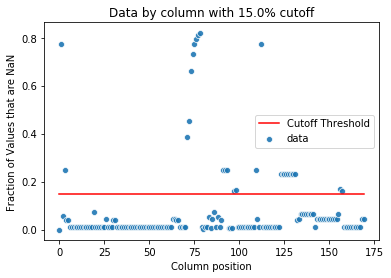

In [11]:
#Dropping idea: Remove columns w/ NaN percent above a threshold, then drop all corresponding rows
nan_cols = dc.get_nan_frac_cols(X, 0.15, graph=True)
print('Columns above threshold:',len(nan_cols))

X_no_nan = X.drop(nan_cols, axis=1).dropna()
X_no_nan.info()

In [12]:
# Display columns to drop
print(nan_cols)

['ab_000', 'ad_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cf_000', 'cg_000', 'ch_000', 'cl_000', 'cm_000', 'co_000', 'cr_000', 'ct_000', 'cu_000', 'cv_000', 'cx_000', 'cy_000', 'cz_000', 'da_000', 'db_000', 'dc_000', 'ec_00', 'ed_000']


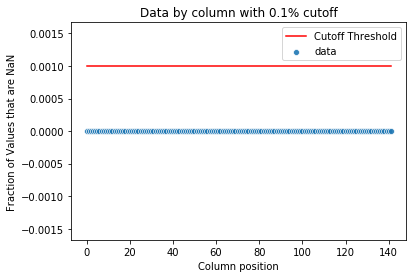

In [13]:
# Visualize the effect
dc.get_nan_frac_cols(X_no_nan, 0.001, graph=True);

In [14]:
# Check that we still have a good amount of negative and positive classes
y_no_nan = y[X_no_nan.index].reset_index(drop=True)
X_no_nan = X_no_nan.reset_index(drop=True)
print('Total remaining observations:',y_no_nan.shape[0])
print('Number of negative class:', np.sum(y_no_nan==0))
print('Number of positive class:', y_no_nan[y_no_nan==1].sum())

Total remaining observations: 54143
Number of negative class: 53738
Number of positive class: 405


Dropping high columns with a high percentage of `NaN` values, then culling the observations with any `NaN` value still leaves 54,143 observations, down from 60,000. We also retained 142 of the 170 featurs. However, of the original 1000 positive examples, only 405 remain. The negative class still has 53,738 observations.  

Percent loss, by class, when indiscriminantly dropping NaN values:
* Positive class: 59.5%
* Negative class:  0.7%  

Takeaways:  
1) I still have enough examples to train on if necessary.  
2) Since the lack of measurements disproportionately affects one class, it could be that the number of missing values is correlated with the class type, and thus should become a feature.  
3) Look at imputing the data instead of running a `pandas.DataFrame.dropna()` after removing high-NaN columns.

**The above takeaways have been accounted for in the `data_cleaning.ready_aps_data` method. While features (columns) missing most measurements are still dropped, the remaining values are imputed. This retains all of the training set examples, doubles the amount of positive class examples, and increases model performance.**  

I also believe it's the approach that conforms better with what would be needed in practice when some measurements are unavailable in the shop and the mechanics still need to make a decision.

## Adding database to SQL

Part of the requirement for this project is to get the data into a SQL database on our AWS server. This would be much more useful if my data was distributed across several tables in a RDMS. I've created a command that iterates through the table columns and creates a string in Postgres SQL syntax that lets me copy/paste the output into a SQL command to create a table.

I don't think it's efficient or safe (teasing out misspellings and the like) to manually type out the table creation command for 170 columns with their respective types. The whole point of relational databases is to partition out information in different tables and to then select only what you need, and this dataset doesn't seem like a good fit with that principle.

In [16]:
# 10 column demo. Remove indexing for full table.
table_creation = tuple(column + ' FLOAT' for column in X.columns[:10])
sql_table_columns = ', '.join(column for column in table_creation)
print(f'CREATE TABLE aps_data ({sql_table_columns});' )

CREATE TABLE aps_data (aa_000 FLOAT, ab_000 FLOAT, ac_000 FLOAT, ad_000 FLOAT, ae_000 FLOAT, af_000 FLOAT, ag_000 FLOAT, ag_001 FLOAT, ag_002 FLOAT, ag_003 FLOAT);


## Testing Classifiers on Data
Two approach philosophies:
* See which naive model has best performance over K folds, then tune that model to optimal performance.
* Tune every model, to include the number of folds in the data, then evaluate those models over 10 folds.

The models run pretty slowly on the data, so I'm going for the first approach where I'll use the vanilla settings to narrow down the field, then tune the model(s) that stand out.

### Split stratified data into train/holdout, then split training data into stratified train/test folds

The SKLearn method StratifiedShuffleSplit is used to split the data into a randomized training and holdout set that maintains the percentage of the positive class in the original data. From there, StratifiedKFolds is used to break the training set into cross-validation folds for assessing model performance.  

The data set has a severe class imbalance, with the positive class ("APS failure") making up <2% of the set. Performing this split is necessary to ensure effective cross-validation.

**Edit:** Sklearn's `train_test_split()` method with the `stratify` parameter will accomplish the same as the method below. At the time I was focused on deliberately shuffling the dataset to make sure that some of the positive class eventually got into each CV fold.

In [17]:
# Make training and holdout sets

sss = StratifiedShuffleSplit(n_splits=1,test_size=0.20, random_state=42)
for train_index, holdout_index in sss.split(X_no_nan,y_no_nan):
    #print("TRAIN:", train_index, "TEST:", holdout_index)
    X_train = X_no_nan.values[train_index]
    X_test = X_no_nan.values[holdout_index]
    y_train = y_no_nan.values[train_index]
    y_test = y_no_nan.values[holdout_index]
    
    #Check that the train/test split does not overlap/include duplicates
    assert(not set(train_index).intersection(set(holdout_index)))

In [18]:
# Validate that splits are even
np.sum(y_test==1)/len(y_test),  np.sum(y_train==1)/len(y_train)

(0.007479915042940253, 0.007480260423881424)

### Naive Performance of Classifiers
The following blocks assess the performance of the vanilla models on the reduced data set using the ROC Area Under the Curve (AUC) assessment metric. A value closer to 1 is desirable.  

Because of the heavy penalty on Type II errors in Scania's cost function, I've also gotten cross-validation scores for some of the models and data transformations using precision as well as ROC AUC.  

Random Forest and Gradient Boosting classifiers stood out for their high AUC and relatively high precision in basic testing.

In [19]:
# Create stratified folds for 10 fold cross-validation
skf = StratifiedKFold(n_splits=10, random_state=42)

In [20]:
# SkLearn Dummy classifier 
np.mean(cross_val_score(DummyClassifier(),X_train,y_train,
                        cv=skf, scoring = 'roc_auc'))

0.4995303149252469

In [21]:
# Absolute baseline: Predicting everything as negative (no check needed)
all_neg = np.zeros(len(y_train))
print(roc_auc_score(y_train, all_neg))
print(scania_score(y_train,all_neg))

0.5
162000


In [24]:
# Baseline: predicting everything as positive (needing a check)
all_pos = np.zeros(len(y_train))+1
print(roc_auc_score(y_train, all_pos))
print(scania_score(y_train, all_pos))

0.5
429900


From the above, it looks like it's cheaper to Scania to not ever check the APS instead of always checking the APS. I think there are plenty of reasons why this still isn't a smart or ethical approach (driver safety among them), so hopefully we can do better using some models.

In [38]:
classifiers = {
    'knn': KNeighborsClassifier,
    'lgr': LogisticRegression,
    'gnb': GaussianNB,
    #'mnb': MultinomialNB
    'bnb': BernoulliNB,
    'dtc': DecisionTreeClassifier,
    'rfc': RandomForestClassifier,
    'gbc': GradientBoostingClassifier,
    'lsvc': LinearSVC,
    # 'svc': SVC   ''' really, really slow'''
}

default_parameters = {
    'knn': {},
    'lgr': {'solver':'liblinear'},
    'gnb': {},
    #'mnb': {},
    'bnb': {},
    'dtc': {},
    'rfc': {'n_estimators':100},
    'gbc': {},
    'lsvc': {},
    # 'svc': {}
}

The following block from `model_abstraction.py` accepts a dictionary of model objects and returns the cross-validation scores for each.

In [39]:
vanilla_unscaled_auc = cross_val_models(classifiers, X_train,y_train, use_cv=skf,
                                        metric='roc_auc', params=default_parameters)
print(vanilla_unscaled_auc)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


defaultdict(<class 'str'>, {'knn': 0.833807743344118, 'lgr': 0.9372424524378467, 'gnb': 0.9496054072652556, 'bnb': 0.9347346238025758, 'dtc': 0.8271712237518238, 'rfc': 0.9729079877631868, 'gbc': 0.9573550512980468, 'lsvc': 0.7038931710686771})


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [42]:
vanilla_unscaled_prcsn = cross_val_models(classifiers, X_train,y_train, use_cv=skf, metric='recall',
                                         params=default_parameters)
print(vanilla_unscaled_prcsn)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


defaultdict(<class 'str'>, {'knn': 0.28674242424242424, 'lgr': 0.5743371212121212, 'gnb': 0.8521780303030303, 'bnb': 0.7716856060606061, 'dtc': 0.6206439393939395, 'rfc': 0.5865530303030303, 'gbc': 0.6017992424242424, 'lsvc': 0.3502840909090909})


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Naive Classifiers using Scaled Data

Looking at the effects of scaled data on model performance. I would only expect changes from models operating in a linear space, such as KNeighbors, Logistic Regression, and SVC's.

In [43]:
ssx = StandardScaler()
scaled_X_train = ssx.fit_transform(X_train)
scaled_X_test = ssx.transform(X_test)

In [44]:
vanilla_scaled = cross_val_models(classifiers, scaled_X_train,y_train, use_cv=skf, metric='roc_auc')
print(vanilla_scaled)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

defaultdict(<class 'str'>, {'knn': 0.8639242433053493, 'lgr': 0.9203227759098311, 'gnb': 0.9457376230906412, 'bnb': 0.9093221556105366, 'dtc': 0.8181143804584577, 'rfc': 0.9323435528523193, 'gbc': 0.9571990402983076, 'lsvc': 0.8733829484658167})


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [46]:
vanilla_scaled_prcsn = cross_val_models(classifiers, scaled_X_train,y_train, use_cv=skf, metric='recall')
print(vanilla_scaled_prcsn)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

defaultdict(<class 'str'>, {'knn': 0.45681818181818185, 'lgr': 0.6053030303030302, 'gnb': 0.8704545454545455, 'bnb': 0.8609848484848485, 'dtc': 0.6207386363636364, 'rfc': 0.5095643939393939, 'gbc': 0.6081439393939394, 'lsvc': 0.5500946969696969})


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Naive Classifiers using PCA-reduced data

Currently working with over 140 features. None of the principal components capture a majority representation of the variance, however I'm going to try putting the reduced components through classification models just to see how the AUC scores change.

In [47]:
pca = PCA(n_components=10)
pca.fit(scaled_X_train)
pca.explained_variance_ratio_

array([0.34499792, 0.06027573, 0.04941278, 0.02883688, 0.02672339,
       0.02257314, 0.01788312, 0.01726799, 0.01596444, 0.01534512])

In [48]:
pca_scaled_X_train = pca.transform(scaled_X_train)

In [49]:
vanilla_scaled_pca_auc = cross_val_models(classifiers, pca_scaled_X_train,y_train,
                                      use_cv=skf, metric='roc_auc', params = default_parameters)
print(vanilla_scaled_pca_auc)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


defaultdict(<class 'str'>, {'knn': 0.8707792664079737, 'lgr': 0.9620230568067276, 'gnb': 0.9567179008331749, 'bnb': 0.8840788048841521, 'dtc': 0.7838390336547612, 'rfc': 0.958045971314682, 'gbc': 0.9637973308627092, 'lsvc': 0.9515936361169265})


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [50]:
vanilla_scaled_pca_prcsn = cross_val_models(classifiers, pca_scaled_X_train,y_train,
                                      use_cv=skf, metric='recall', params = default_parameters)
print(vanilla_scaled_pca_prcsn)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


defaultdict(<class 'str'>, {'knn': 0.43863636363636366, 'lgr': 0.44176136363636365, 'gnb': 0.7505681818181819, 'bnb': 0.0, 'dtc': 0.5679924242424242, 'rfc': 0.5429924242424242, 'gbc': 0.47547348484848484, 'lsvc': 0.37339015151515154})


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Basic Model for MVP Reporting Purposes
The following model was used to provide an update to my cohort in a short 30 second long presentation on where my project was going. **Note:** At this point I hadn't found Scania's actual test set on Kaggle (I was using the version from UCI's ML Repository).

In [25]:
# For MVP purposes, training vanilla GBM on X_train
grb = GradientBoostingClassifier().fit(X_train,y_train)
y_pred = grb.predict(X_test)

In [26]:
print(roc_auc_score(y_test, y_pred))
print(scania_score(y_test, y_pred))
print(roc_auc_score(y_no_nan, grb.predict(X_no_nan)))
print(scania_score(y_no_nan, grb.predict(X_no_nan)))

0.8266952909987273
14100
0.9233544416921791
31110


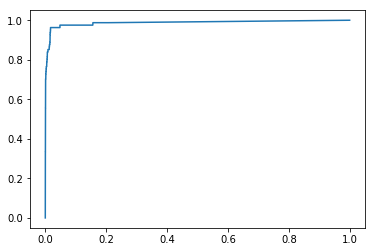

In [28]:
fpr, tpr, ths = roc_curve(y_test, grb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)

In [89]:
# Test set results
confusion_matrix(y_test, y_pred)

array([[10729,    19],
       [   25,    56]])

In [91]:
# for mvp
confusion_matrix(y_no_nan, y_pred_whole)

array([[53715,    23],
       [   64,   341]])

# Webapp model
Code for a simple flask web app using a very reduced version of the data. Scale it down to one feature with PCA then train a model. Export the model and the scaler to a pickle file, then bring it into the cupcake_or_muffin folder in the in_progress directory.

In [78]:
best_model = GradientBoostingClassifier().fit(pca_X_train,y_train)
model_export = {'PCA_Reduction':pca,
               'model': best_model}
pickle.dump(model_export, open("scania_model_for_webapp.pkl","wb"))
best_model.predict(np.array([.88]).reshape(-1,1))[0]

# Model Tuning
At this point I'm looking at 3 models, for different types of data:
* Gradient Boosting on full data set, scaled
* Random Forest and Gradient Boosting on PCA'ed data and regular data

See [this guide](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) for Gradient Boosting hyperparameter tuning.

In [30]:
'''    ********      MAKE THIS INTO A FUNCTION    ********        '''

model = GradientBoostingClassifier
const_params = {'random_state':42}
tuning_params = {'min_samples_split':[2,10,30,100],
                'max_depth':[3,5,10],
                'max_features':['auto', 'log2', None],
                'n_estimators':[5,10,50,100],
                 'subsample':[1,0.9,0.8, 0.7],
                }
metric = 'roc_auc'
use_cv = skf

grid_gb_scaled = RandomizedSearchCV(model(**const_params), tuning_params, scoring = metric,
                             iid=False, cv=use_cv, n_iter = 20)
grid_gb_scaled.fit(scaled_X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
          error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=20, n_jobs=None,
          param_distributions={'min_samples_split': [2, 10, 30, 100], 'max_depth': [3, 5, 10], 'max_features': ['auto', 'log2', None], 'n_estimators': [5, 10, 50, 100], 'subsample': [1, 0.9, 0.8, 0.7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [33]:
print('Best CV score:', grid_gb_scaled.best_score_)
print('Test Score', roc_auc_score(y_test,grid_gb_scaled.predict(scaled_X_test)))

Best CV score: 0.9705760390894289
Test Score 0.7581892927538629


In [31]:
scania_score(y_test,grid_gb_scaled.predict(scaled_X_test))

19730

In [32]:
grid_gb_scaled.best_params_

{'subsample': 1,
 'n_estimators': 50,
 'min_samples_split': 2,
 'max_features': 'log2',
 'max_depth': 10}

In [34]:
model = GradientBoostingClassifier
const_params = {'random_state':42}
tuning_params = {'min_samples_split':[2,10,30,100],
                'max_depth':[3,5,10],
                'max_features':['auto', 'log2', None],
                'n_estimators':[5,10,50,100],
                 'subsample':[1,0.9,0.8, 0.7],
                }
metric = 'roc_auc'
use_cv = skf

grid_gb_pca_scaled = RandomizedSearchCV(model(**const_params), tuning_params, scoring = metric,
                             iid=False, cv=use_cv, n_iter = 10)
grid_gb_pca_scaled.fit(pca_scaled_X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
          error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=10, n_jobs=None,
          param_distributions={'min_samples_split': [2, 10, 30, 100], 'max_depth': [3, 5, 10], 'max_features': ['auto', 'log2', None], 'n_estimators': [5, 10, 50, 100], 'subsample': [1, 0.9, 0.8, 0.7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [35]:
print(scania_score(y_test,grid_gb_pca_scaled.predict(pca.transform(scaled_X_test))))
grid_gb_pca_scaled.best_params_

19230


{'subsample': 0.9,
 'n_estimators': 100,
 'min_samples_split': 30,
 'max_features': None,
 'max_depth': 5}

In [37]:
print('Best CV score:', grid_gb_pca_scaled.best_score_)
print('Test Score', roc_auc_score(y_test,grid_gb_pca_scaled.predict(pca.transform(scaled_X_test))))

Best CV score: 0.9653572315972003
Test Score 0.7643621322600358


### Bringing in Gradient Boosting algorithm from XGBoost library.
The following blocks first test the general viability of an untrained XGBoost algorithm, then go into the appropriate cross-validation action.

In [51]:
import xgboost as xgb

In [77]:
gbm = xgb.XGBClassifier( 
                       n_estimators=30000, #arbitrary large number b/c we're using early stopping
                       max_depth=3,
                       objective="binary:logistic", 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(scaled_X_train,y_train),(scaled_X_test,y_test)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    scaled_X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=50, # stop when validation error hasn't improved in this many rounds
                    verbose=False #gives output log as below
                   )

In [78]:
# Gauging model performance with default prediction threshold
test = fit_model.predict(scaled_X_test, ntree_limit=gbm.best_ntree_limit)
print(scania_score(y_test,test))
print(roc_auc_score(y_test,test))
confusion_matrix(y_test,test)

21010
0.7406942204578973


array([[10747,     1],
       [   42,    39]])

In [80]:
# Guaging model performance with lower threshold
test = fit_model.predict_proba(scaled_X_test, ntree_limit=gbm.best_ntree_limit)[:,1] > 0.03
print(scania_score(y_test,test))
print(roc_auc_score(y_test,test))
confusion_matrix(y_test,test)

4460
0.9677114777598588


array([[10452,   296],
       [    3,    78]])

Actually cross-validating model, then checking score on test set.

In [62]:
cross_val_score(gmb, aps_dm, scoring='auc')

cv_scores = []
for train_idx, val_idx in skf.split(X_train, y_train):
    
    X_tr = X_train[train_idx]
    y_tr = y_train[train_idx]
    X_val = X_train[val_idx]
    y_val = y_train[val_idx]
   
    gbm = xgb.XGBClassifier( 
                       n_estimators=30000, #arbitrary large number b/c we're using early stopping
                       max_depth=3,
                       objective="binary:logistic",
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )
    eval_set=[(X_tr,y_tr),(X_val,y_val)] #tracking train/validation error as we go
    fit_model = gbm.fit( 
                    X_tr, y_tr, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=50, # stop when validation error hasn't improved in this many rounds
                    verbose=False #gives output log as below
                   )
    
    y_val_pred = fit_model.predict_proba(X_val, ntree_limit=gbm.best_ntree_limit)[:,1]
    cv_scores.append(roc_auc_score(y_val,y_val_pred > 0.03))
    
    
print(np.mean(cv_scores))

0.9249411200279136


In [64]:
# Evaluating last fold's model
cutoff = 0.03
y_test_pred = fit_model.predict_proba(X_test)[:,1] > cutoff

print(roc_auc_score(y_test,y_test_pred))
print(scania_score(y_test,y_test_pred))
confusion_matrix(y_test,y_test_pred)

0.9571479276075481
4250


array([[10623,   125],
       [    6,    75]])

# Takeaways
Ensemble models like Gradient Boosting and Random Forest seem to work the best. Random Forest, specifically, seems to score high on AUC but also on precision, which should help avoid false negatives. I haven't yet figured out how to integrate Scania's error metric into the SKLearn environment, so I'll need to adapt something like the above block into my own cross validation function for future analysis. I've been using the ROC AUC metric as a stand-in, and while it does let me cut the wheat from the chaff, it doesn't align well enough with the Scania cost to make a final model decision.

The scores above look good, although they are not done on the true test set for the competition (see `02_classification_testing.ipynb` for that).  

There are two process improvements I'm looking to add that can take this model further:
* The above tests were done on a data set where I didn't impute any missing rows, meaning I lost half my positive class (albeit still keeping just under 500 and stratifying). **Imputing the data and engineering features that acknowledge the 'na' values** (because even missing measurements mean something) will have an effect on model performance.
* **Tuning the decision threshold.** I didn't realize this until I was running XGBoost and discovered that it prints out decimal values by default on its predict method. This had an extraordinary effect on lowering Scania's custom cost score, and I imagine changing that threshold will have similar effects for the Random Forest Classifier as well.

In [84]:
X_no_nan['data'] = y_no_nan
correlations = X_no_nan.corr()
correlations['data'].sort_values(ascending=False)

data      1.000000
bj_000    0.492298
am_0      0.478334
aq_000    0.465263
al_000    0.461792
bb_000    0.449540
bv_000    0.449540
bu_000    0.449540
cq_000    0.449540
ap_000    0.440616
bg_000    0.437689
ah_000    0.437689
ci_000    0.437532
an_000    0.433719
ao_000    0.425696
dn_000    0.421138
bh_000    0.420361
bt_000    0.417634
aa_000    0.417634
ck_000    0.396130
cc_000    0.391366
bx_000    0.382500
by_000    0.378954
ee_005    0.370739
cj_000    0.361503
ds_000    0.359379
dt_000    0.354983
cs_004    0.351365
ba_004    0.340400
cn_004    0.335950
            ...   
ag_008    0.072418
az_006    0.069360
ai_000    0.065010
cp_000    0.063463
ag_009    0.058421
az_008    0.053314
ca_000    0.052061
ay_009    0.049906
dh_000    0.047875
cb_000    0.047305
dk_000    0.023207
eg_000    0.020316
cs_007    0.015957
aj_000    0.015029
af_000    0.014378
ak_000    0.010191
dm_000    0.007623
ef_000    0.006269
ea_000    0.005837
az_009    0.002972
ag_000    0.001886
ae_000    0.

In [86]:
X_no_nan['cd_000'].value_counts()

1209600.0    54143
Name: cd_000, dtype: int64

In [87]:
aps['cd_000'].value_counts()

1209600    59324
na           676
Name: cd_000, dtype: int64